In [20]:
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vectorbt as vbt
from datetime import datetime
import plotly.offline as pyo
import math
from datetime import datetime

In [22]:
import os
import csv
from binance.client import Client
api_key = os.environ.get('binance_api')
api_secret = os.environ.get('binance_secret')
client = Client(api_key, api_secret)

In [23]:
timestamp = client._get_earliest_valid_timestamp('BTCUSDT', '2h')  //設定起始時間

time
Open
High
Low
Close
Volume
Closetime
Quote asset volume
Numberoftrades
Takerbuybaseassetvolume
Takerbuyquoteassetvolume
Ignore
valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M

In [24]:
bars = client.get_historical_klines('BTCUSDT', '2h', timestamp)  
with open('2h.csv', 'w', newline='') as f:
    for line in bars:
        del line[6:]
    df = pd.DataFrame(bars, columns=['date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['seconds'] = np.floor_divide(df['date'], 1000)
    df['date'] = df['seconds'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    df.set_index('date', inplace=True)
    print(df.head())
    df.to_csv('2h.csv')


                              Open           High            Low  \
date                                                               
2017-08-17 12:00:00  4261.48000000  4328.69000000  4261.32000000   
2017-08-17 14:00:00  4330.29000000  4349.99000000  4287.41000000   
2017-08-17 16:00:00  4333.32000000  4445.78000000  4333.32000000   
2017-08-17 18:00:00  4441.10000000  4485.39000000  4399.81000000   
2017-08-17 20:00:00  4436.06000000  4459.00000000  4411.00000000   

                             Close       Volume     seconds  
date                                                         
2017-08-17 12:00:00  4315.32000000  70.41592500  1502942400  
2017-08-17 14:00:00  4349.99000000  11.67294000  1502949600  
2017-08-17 16:00:00  4444.00000000  11.73643000  1502956800  
2017-08-17 18:00:00  4427.30000000  51.88345200  1502964000  
2017-08-17 20:00:00  4459.00000000  54.34483400  1502971200  


In [26]:
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)

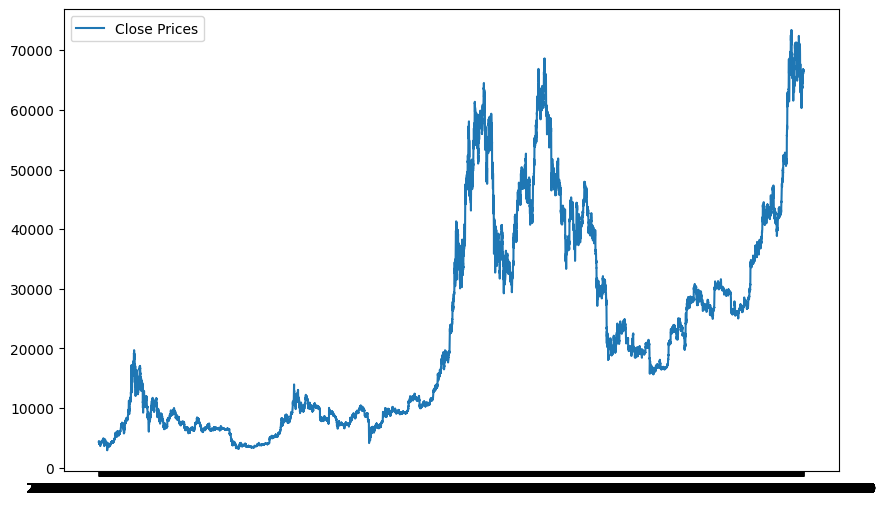

In [27]:
#plot
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Prices')
plt.legend()
plt.show()

In [28]:
#define goal def

def crossover(over, down):
    a1 = over
    b1 = down
    a2 = a1.shift(1)
    b2 = b1.shift(1)
    crossover = (a1 > a2) & (a1 > b1) & (b2 > a2)
    return crossover
def crossdown(down, over):
    a1 = down
    b1 = over
    a2 = a1.shift(1)
    b2 = b1.shift(1)
    crossdown = (a1 < a2) & (a1 < b1) & (b2 < a2)
    return crossdown



In [29]:
rvi_length = 2
rvi_ma_length = 18
kclength = 31
kc_mult = 2

price_diff = np.diff(df['Close'])
df = df.iloc[1:, :]                                                      
df['price_diff'] = price_diff                                     
df['stddev'] = df['Close'].rolling(window=rvi_length).std()              
df['upper'] = np.where(df['price_diff'] <= 0, 0, df['stddev'])           
df['upper'] = df['upper'].ewm(span=rvi_length, adjust=False).mean()
df['lower'] = np.where(df['price_diff'] > 0, 0, df['stddev'])
df['lower'] = df['lower'].ewm(span=rvi_length, adjust=False).mean()
df['rvi'] = df['upper'] / (df['upper'] + df['lower']) *100
df['rvi_ma'] = df['rvi'].rolling(rvi_ma_length).mean()
df.dropna(inplace=True)

df['sma'] = df['Close'].rolling(kclength).mean()
df['basis'] = df['Close'].ewm(span=kclength, adjust=False).mean()
df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=kclength)
df['kc_upper'] = df['basis'] + kc_mult * df['atr']
df['kc_lower'] = df['basis'] - kc_mult * df['atr']
df.dropna(inplace=True)


In [30]:
#signal
signal = pd.DataFrame(columns=['long_entry', 'short_entry', 'long_exit', 'short_exit'])
signal['long_entry'] = np.where((crossover(df['Close'], df['kc_upper']) & (df['rvi'] > df['rvi_ma'])), 1, 0)
signal['long_exit'] = np.where((crossdown(df['Close'], df['basis']) & (df['rvi'] < df['rvi_ma'])), 1, 0) 
signal['short_entry'] = np.where((crossdown(df['Close'], df['kc_lower']) & (df['rvi'] < df['rvi_ma'])), 1, 0)
signal['short_exit'] = np.where((crossover(df['Close'], df['basis']) & (df['rvi'] > df['rvi_ma'])), 1, 0)

In [31]:
#pf
price = df['Open'].shift(-1)
pf = vbt.Portfolio.from_signals(price,
                            entries = signal['long_entry'],
                            exits = signal['long_exit'],
                            short_entries = signal['short_entry'],
                            short_exits = signal['short_exit'],
                            freq='2H',
                            fees = 0.0005)

print(pf.stats())
fig = pf.plot(subplots=['cum_returns', 'orders', 'trade_pnl'])
pyo.plot(fig)

Start                               2017-08-21 16:00:00
End                                 2024-04-24 10:00:00
Period                               2433 days 10:00:00
Start Value                                       100.0
End Value                                   1267.568613
Total Return [%]                            1167.568613
Benchmark Return [%]                        1541.496557
Max Gross Exposure [%]                            100.0
Total Fees Paid                              320.697143
Max Drawdown [%]                              48.000125
Max Drawdown Duration                 522 days 18:00:00
Total Trades                                        548
Total Closed Trades                                 548
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  36.861314
Best Trade [%]                                32.483487
Worst Trade [%]                              -16

'temp-plot.html'